<a href="https://colab.research.google.com/github/amirhosein-ziaei/knowledge-distillation-CIFAR10/blob/utils/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Transfer learning using Resnet50 model on Cifar10 dataset

In this part, first we load cifar10 dataset from utils.py, then some sample images with their corresponding labels are plotted. For transfer learning, Resnet50 model is loaded with Imagenet weights

In [1]:
# Importing libraries
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from utils import *
from keras.applications.resnet50 import preprocess_input

In [2]:
# Loading cifar10 dataset
(x_train, y_train), (x_test, y_test), (x_val, y_val) = load_cifar10(val_ratio = 0.1)  # 0.1 of training set is valdiation set

170498071/170498071 [==============================] - 4s 0us/step


In [3]:
# Mounting google drive to google colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Defining classes exist in Cifar10
classes = ['airplane' , 'automobile' , 'bird' , 'cat' , 'deer' , 'dog' , 'frog' , 'horse' , 'ship' ,'truck' ]
num_to_class_dic = {i:classes[i] for i in range(len(classes))} # A dictionary that maps numbers 0 , 1 , 2 , ... to classes
class_to_num_dic = {classes[i]:i for i in range(len(classes))} # A dictionary that maps classes to numbers 0 , 1 , 2 , ...
print(f'number to class dictionary :\n{num_to_class_dic}')
print(f'class to number dictionary :\n{class_to_num_dic}')

number to class dictionary :
{0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}
class to number dictionary :
{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}


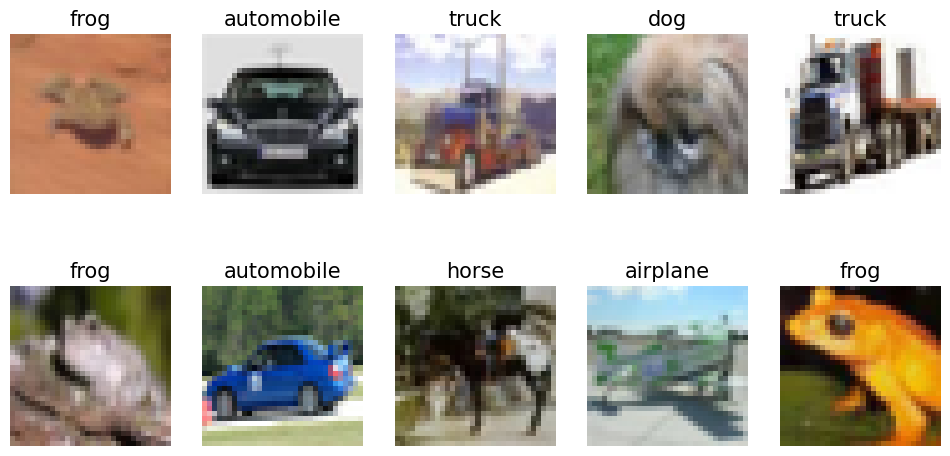

In [5]:
# Plotting some samples from dataset
sample_plot(x = x_train , y = y_train , num_to_class_dic = num_to_class_dic)

In [7]:
# Using transfer learning with resnet50
resnet_model = ResNet50_model() # Loading Resnet50 model with input shape (224,224,3)( ResNet50_model)
input = keras.Input((32,32,3))
x = tf.keras.layers.UpSampling2D(size=(7,7))(input) # Changing the input shape from (32,32,3) to (224,224,3) in order the inputs fit the desired input of ResNet50 model
x = resnet_model(x)
x = keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(256, activation="relu")(x)
output = tf.keras.layers.Dense(10, activation="softmax")(x)
customized_resnet_model = keras.Model(inputs = input , outputs = output)
customized_resnet_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 up_sampling2d (UpSampling2  (None, 224, 224, 3)       0         
 D)                                                              
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               104908

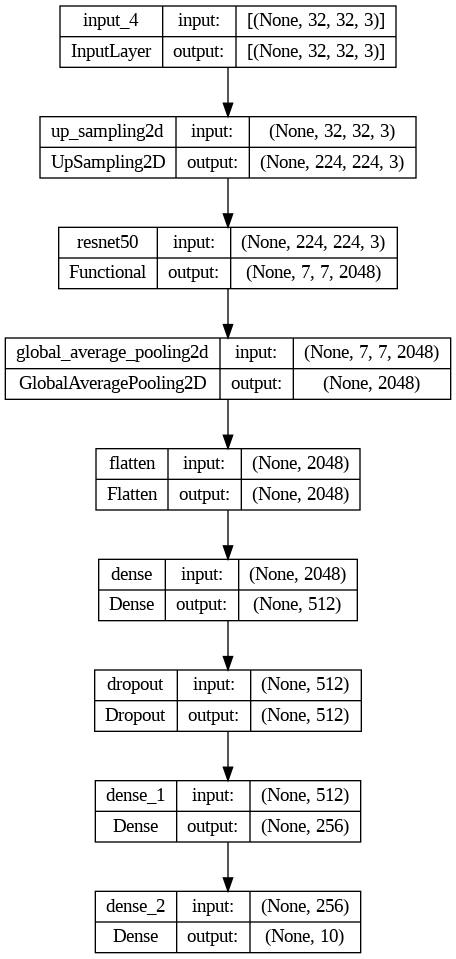

In [8]:
from keras.utils import plot_model
plot_model(customized_resnet_model, show_shapes=True, show_layer_names=True)

In [9]:
# callbacks

# Checkpoint callback
from tensorflow.keras.callbacks import ModelCheckpoint
myCP = ModelCheckpoint(save_best_only=True,filepath='/content/drive/MyDrive/customized_resnet_model.h5',monitor = 'val_accuracy')

# Earlystopping callback
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2, verbose=1, restore_best_weights=True) # Early stopping callback


In [12]:
# Compiling the model
customized_resnet_model.compile(loss = keras.losses.CategoricalCrossentropy(),
                    optimizer = keras.optimizers.Adam(learning_rate = 3e-4),
                    metrics = ['accuracy',precision,recall]  # precision and recall defined in utils.py
                )
history = customized_resnet_model.fit(x_train , y_train , batch_size = 64 ,validation_data = (x_val , y_val) , epochs = 5 , callbacks = [early_stopping , myCP])

Epoch 1/5
704/704 [==============================] - ETA: 0s - loss: 0.3828 - accuracy: 0.8720 - precision: 0.9032 - recall: 0.8425

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


704/704 [==============================] - 502s 670ms/step - loss: 0.3828 - accuracy: 0.8720 - precision: 0.9032 - recall: 0.8425 - val_loss: 0.5481 - val_accuracy: 0.8184 - val_precision: 0.8759 - val_recall: 0.7567
Epoch 2/5
704/704 [==============================] - 484s 688ms/step - loss: 0.2162 - accuracy: 0.9269 - precision: 0.9414 - recall: 0.9142 - val_loss: 0.3380 - val_accuracy: 0.8890 - val_precision: 0.9076 - val_recall: 0.8778
Epoch 3/5
704/704 [==============================] - 465s 661ms/step - loss: 0.1506 - accuracy: 0.9496 - precision: 0.9573 - recall: 0.9424 - val_loss: 0.4112 - val_accuracy: 0.8678 - val_precision: 0.8903 - val_recall: 0.8485
Epoch 4/5
704/704 [==============================] - 472s 671ms/step - loss: 0.1145 - accuracy: 0.9606 - precision: 0.9653 - recall: 0.9554 - val_loss: 0.5285 - val_accuracy: 0.8564 - val_precision: 0.8680 - val_recall: 0.8497
Epoch 5/5
704/704 [==============================] - 481s 683ms/step - loss: 0.1033 - accuracy: 0.9651

In [13]:
customized_resnet_model.save('/content/drive/MyDrive/customized_resnet_model.h5') # Saving the model in google drive

313/313 [==============================] - 32s 92ms/step


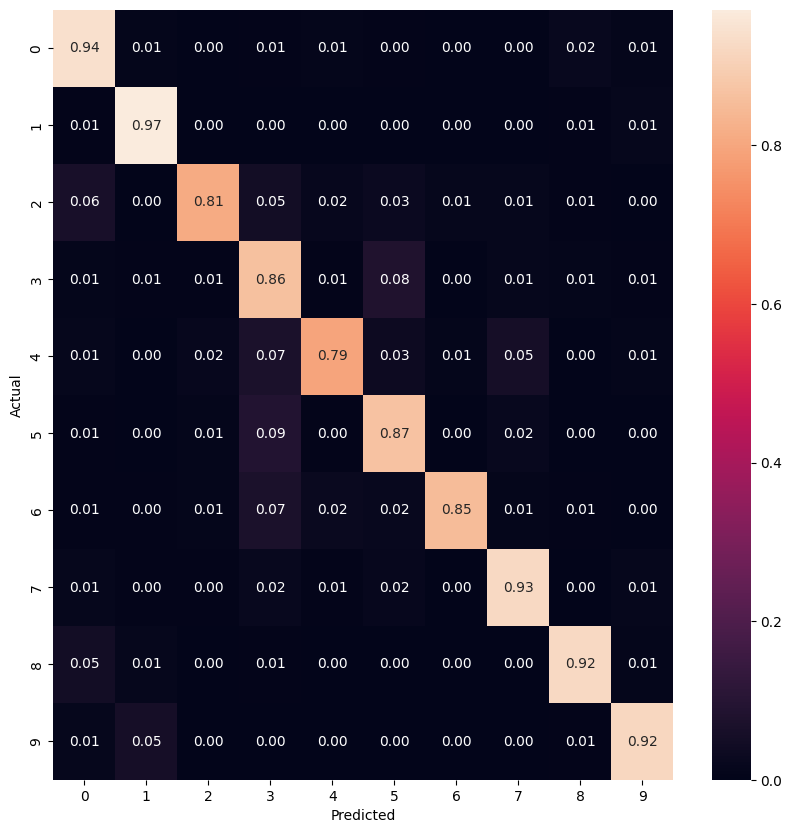

In [14]:
# Plotting the confusion matrix
plot_confusion_matrix(customized_resnet_model ,x_test , y_test)

In [15]:
# Evaluating the x_test , y_test
customized_resnet_model.evaluate(x_test , y_test)

313/313 [==============================] - 29s 92ms/step - loss: 0.3895 - accuracy: 0.8865 - precision: 0.8984 - recall: 0.8791


[0.3895428776741028,
 0.8865000009536743,
 0.8983792662620544,
 0.8790934681892395]